In [23]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.covariance import LedoitWolf

# Data fetching
# Custom data fetcher to replace broken YahooDataProvider
# The qiskit-finance YahooDataProvider has compatibility issues with latest yfinance
import yfinance as yf

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [24]:
# Portfolio parameters
# Data parameters
START_DATE = datetime.now() - timedelta(days=365*2)  # 2 years of data
END_DATE = datetime.now()

# S&P 500 stocks (diversified sector selection)
TICKERS = [
    # Technology
    'NVDA',  # NVIDIA
    'MSFT',  # Microsoft
    'AAPL',  # Apple
    'AMZN',  # Amazon
    'META',  # Meta
    'AVGO',  # Broadcom
    'GOOGL', # Alphabet
    'TSLA',  # Tesla
    'BRK-B', # Berkshire Hathaway
    'WMT',   # Walmart
]


print(f"Configuration:")
print(f"  Tickers: {TICKERS}")
print(f"  Date range: {START_DATE.date()} to {END_DATE.date()}")

Configuration:
  Tickers: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'TSLA', 'BRK-B', 'WMT']
  Date range: 2023-10-22 to 2025-10-21


In [25]:
def fetch_stock_data(tickers, start_date, end_date):
    """
    Fetch stock data and compute returns, covariance, and correlation.

    Args:
        tickers: List of ticker symbols
        start_date: Start date
        end_date: End date

    Returns:
        mean_returns, covariance_matrix, daily_returns, prices
    """
    print(f"Fetching data for {len(tickers)} stocks from Yahoo Finance...")

    # Download data
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False, progress=False)

    # Extract adjusted close prices
    if len(tickers) == 1:
        prices = data['Adj Close'].to_frame()
        prices.columns = tickers
    else:
        prices = data['Adj Close']

    # Drop any NaN values
    prices = prices.dropna()

    print(f"Downloaded {len(prices)} days of price data")

    # Calculate daily returns
    returns = prices.pct_change().dropna()

    # Calculate mean returns (daily)
    mean_returns = returns.mean().values

    # Calculate sample covariance matrix (daily)
    sample_covariance_matrix = returns.cov().values

    return mean_returns, sample_covariance_matrix, returns, prices

mean_returns, covariance_matrix, daily_returns, price_data = fetch_stock_data(
    TICKERS, START_DATE, END_DATE
)

print(f"\nData fetched successfully!")
print(f"Mean returns shape: {mean_returns.shape}")
print(f"Covariance matrix shape: {covariance_matrix.shape}")
print(f"Daily returns shape: {daily_returns.shape}")

Fetching data for 10 stocks from Yahoo Finance...
Downloaded 501 days of price data

Data fetched successfully!
Mean returns shape: (10,)
Sample covariance matrix shape: (10, 10)
Daily returns shape: (500, 10)


In [26]:
for i, ticker in enumerate(TICKERS):
    print(f"  {ticker}: {mean_returns[i]*252:.2%}")  # Annualized (252 trading days)

  NVDA: 25.74%
  MSFT: 32.83%
  AAPL: 84.40%
  AMZN: 20.77%
  META: 35.87%
  AVGO: 49.54%
  GOOGL: 25.93%
  TSLA: 85.22%
  BRK-B: 56.86%
  WMT: 38.25%


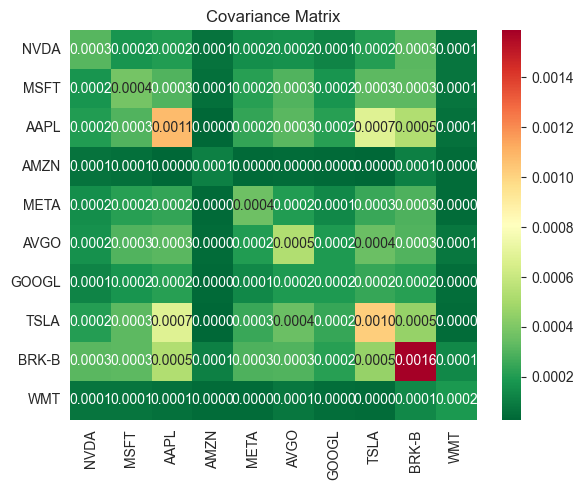

In [27]:
# Visualize covariance matrix - single plot version
plt.figure(figsize=(6, 5))

# Covariance matrix
sns.heatmap(covariance_matrix, annot=True, fmt='.4f', cmap='RdYlGn_r',
            xticklabels=TICKERS, yticklabels=TICKERS)
plt.title('Covariance Matrix')

plt.tight_layout()
plt.show()

In [28]:
covariance_matrix

array([[3.13965405e-04, 1.75168732e-04, 2.00230722e-04, 6.58369176e-05,
        1.51805508e-04, 1.65319014e-04, 1.24710490e-04, 2.08614036e-04,
        3.16956011e-04, 7.47120938e-05],
       [1.75168732e-04, 3.80185773e-04, 2.99257087e-04, 5.86844773e-05,
        2.12050912e-04, 3.01372166e-04, 1.74753787e-04, 3.23592717e-04,
        3.21528341e-04, 7.70277798e-05],
       [2.00230722e-04, 2.99257087e-04, 1.08158951e-03, 2.84030529e-05,
        2.37130973e-04, 3.17215427e-04, 2.11812389e-04, 6.77288795e-04,
        5.31456680e-04, 5.97514657e-05],
       [6.58369176e-05, 5.86844773e-05, 2.84030529e-05, 1.08918129e-04,
        3.63237238e-05, 4.62757681e-05, 3.76226613e-05, 3.34029589e-05,
        1.08744452e-04, 4.38767636e-05],
       [1.51805508e-04, 2.12050912e-04, 2.37130973e-04, 3.63237238e-05,
        3.62849941e-04, 2.03092074e-04, 1.34981559e-04, 2.51656182e-04,
        2.94588562e-04, 4.36208464e-05],
       [1.65319014e-04, 3.01372166e-04, 3.17215427e-04, 4.62757681e-05,
   

In [29]:
# Ledoit-Wolf Shrinkage
lw_estimator = LedoitWolf()
lw_estimator.fit(daily_returns)

shrunk_cov_matrix = lw_estimator.covariance_

print("Ledoit-Wolf Estimator")
print(f"Optimal shrinkage coefficient (delta*): {lw_estimator.shrinkage_:.6f}")
print(f"Shrunk covariance matrix shape: {shrunk_cov_matrix.shape}")

Ledoit-Wolf Estimator
Optimal shrinkage coefficient (delta*): 0.044880
Shrunk covariance matrix shape: (10, 10)


In [30]:
shrunk_cov_matrix

array([[3.25116829e-04, 1.66972463e-04, 1.90861784e-04, 6.27563616e-05,
        1.44702421e-04, 1.57583620e-04, 1.18875198e-04, 1.98852838e-04,
        3.02125414e-04, 7.12162620e-05],
       [1.66972463e-04, 3.88238700e-04, 2.85254636e-04, 5.59385890e-05,
        2.02128900e-04, 2.87270749e-04, 1.66576934e-04, 3.08451584e-04,
        3.06483802e-04, 7.34235953e-05],
       [1.90861784e-04, 2.85254636e-04, 1.05682325e-03, 2.70740539e-05,
        2.26035447e-04, 3.02372692e-04, 2.01901537e-04, 6.45597972e-04,
        5.06589445e-04, 5.69556523e-05],
       [6.27563616e-05, 5.59385890e-05, 2.70740539e-05, 1.29663861e-04,
        3.46241110e-05, 4.41104921e-05, 3.58622703e-05, 3.18400108e-05,
        1.03656222e-04, 4.18237388e-05],
       [1.44702421e-04, 2.02128900e-04, 2.26035447e-04, 3.46241110e-05,
        3.71714023e-04, 1.93589252e-04, 1.28665676e-04, 2.39881010e-04,
        2.80804554e-04, 4.15797960e-05],
       [1.57583620e-04, 2.87270749e-04, 3.02372692e-04, 4.41104921e-05,
   